In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Chapter 1
Nothing much, basically the introduction

# Chapter 2

* Decision tree models consist of step functions of input features. Hence, models based on space-partitioning trees (decision trees, gradient boosted machines, random for‐ ests) are not sensitive to scale

* Taken to an extreme, complex features may themselves be the output of statistical models. This is a concept known as model stacking, which we discuss in much more detail in Chapters 7 and 8. In this chapter, we give the simplest example of complex features: interaction features.


In [13]:
import json
biz_file = open('yelp_academic_dataset_business.json')
biz_df = pd.DataFrame([json.loads(x) for x in biz_file.readlines()]) 
biz_file.close()

Text(0, 0.5, 'Occurrence')

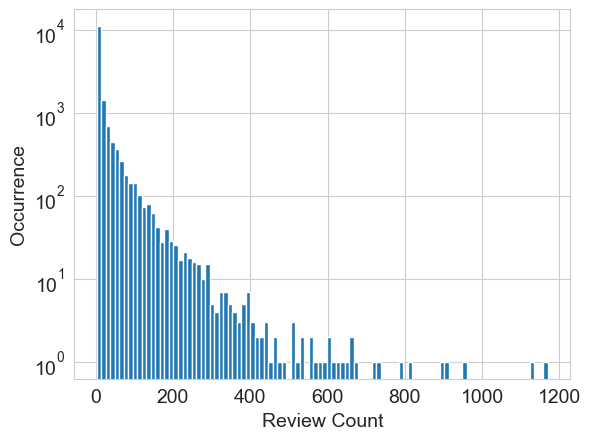

In [17]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
biz_df['review_count'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Review Count', fontsize=14)
ax.set_ylabel('Occurrence', fontsize=14)

In [22]:
# Using the previously loaded Yelp reviews DataFrame,
# compute the log transform of the Yelp review count.
# Note that we add 1 to the raw count to prevent the logarithm from # exploding into negative infinity in case the count is zero.
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
biz_df['log_review_count'] = np.log10(biz_df['review_count'] + 1)
# Train linear regression models to predict the average star rating of a business, # using the review_count feature with and without log transformation.
# Compare the 10-fold cross validation score of the two models.
m_orig = linear_model.LinearRegression()
scores_orig = cross_val_score(m_orig, biz_df[['review_count']], biz_df['stars'], cv=10)
m_log = linear_model.LinearRegression()
scores_log = cross_val_score(m_log, biz_df[['log_review_count']], biz_df['stars'], cv=10)
print("R-squared score without log transform: %0.5f (+/- %0.5f)" % (scores_orig.mean(), scores_orig.std() * 2))
print("R-squared score with log transform: %0.5f (+/- %0.5f)" % (scores_log.mean(), scores_log.std() * 2))

R-squared score without log transform: 0.00179 (+/- 0.00417)
R-squared score with log transform: 0.00069 (+/- 0.00585)


# Power transforms: Generalization of the log transforms

* The log transform is a specific example of a family of transformations known as power transforms. In statistical terms, these are variance-stabilizing transformations. To understand why variance stabilization is good, consider the Poisson distribution. This is a heavy-tailed distribution with a variance that is equal to its mean: hence, the larger its center of mass, the larger its variance, and the heavier the tail. Power trans‐ forms change the distribution of the variable so that the variance is no longer depen‐ dent on the mean.

* The Box-Cox formulation only works when the data is positive. For nonpositive data, one could shift the values by adding a fixed constant. When applying the Box-Cox transformation or a more general power transform, we have to determine a value for the parameter λ. This may be done via maximum likelihood (finding the λ that maxi‐ mizes the Gaussian likelihood of the resulting transformed signal) or Bayesian meth‐ ods. A full treatment of the usage of Box-Cox and general power transforms is outside the scope of this book. Interested readers may find more information on power transforms in Econometric Methods by Johnston and DiNardo (1997). Fortu‐ nately, SciPy’s stats package contains an implementation of the Box-Cox transfor‐ mation that includes finding the optimal transform parameter. Example 2-12 demonstrates its use on the Yelp reviews dataset.

In [33]:
from scipy import stats
# Continuing from the previous example, assume biz_df contains
# the Yelp business reviews data.
# The Box-Cox transform assumes that input data is positive.
# Check the min to make sure.
biz_df['review_count'].min()
# Setting input parameter lmbda to 0 gives us the log transform (without
# constant offset)
rc_log = stats.boxcox(biz_df['review_count'], lmbda=0)
# By default, the scipy implementation of Box-Cox transform finds the lambda # parameter that will make the output the closest to a normal distribution
rc_bc, bc_params = stats.boxcox(biz_df['review_count'])
bc_params
biz_df['rc_bc'] = rc_bc
biz_df['rc_log'] = rc_log

Text(0, 0.5, 'Occurrence')

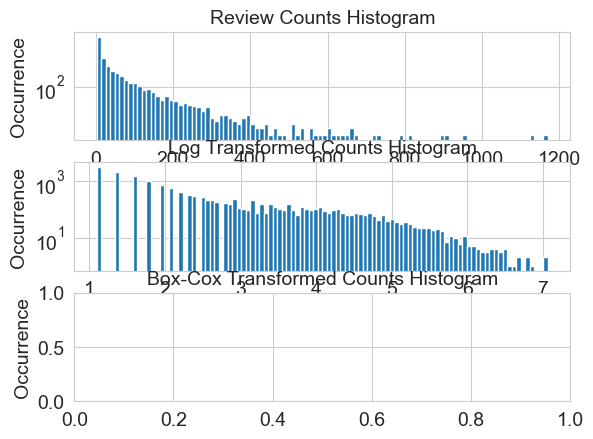

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
# original review count histogram
biz_df['review_count'].hist(ax=ax1, bins=100)
ax1.set_yscale('log')
ax1.tick_params(labelsize=14)
ax1.set_title('Review Counts Histogram', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Occurrence', fontsize=14)

# review count after log transform
biz_df['rc_log'].hist(ax=ax2, bins=100)
ax2.set_yscale('log')
ax2.tick_params(labelsize=14)
ax2.set_title('Log Transformed Counts Histogram', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('Occurrence', fontsize=14)
# review count after optimal Box-Cox transform >>> biz_df['rc_bc'].hist(ax=ax3, bins=100) >>> ax3.set_yscale('log')
ax3.tick_params(labelsize=14)
ax3.set_title('Box-Cox Transformed Counts Histogram', fontsize=14)
ax3.set_xlabel('')
ax3.set_ylabel('Occurrence', fontsize=14)

Text(0.5, 1.0, 'Probplot after Box-Cox transform')

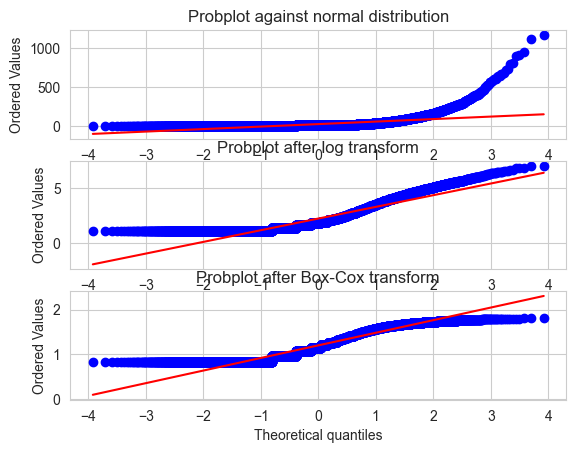

In [36]:
fig2, (ax1, ax2, ax3) = plt.subplots(3,1)
prob1 = stats.probplot(biz_df['review_count'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
prob2 = stats.probplot(biz_df['rc_log'], dist=stats.norm, plot=ax2)
ax2.set_xlabel('')
ax2.set_title('Probplot after log transform')
prob3 = stats.probplot(biz_df['rc_bc'], dist=stats.norm, plot=ax3)
ax3.set_xlabel('Theoretical quantiles')
ax3.set_title('Probplot after Box-Cox transform')

# Feature Scaling 

* Models that are smooth func‐ tions of the input, such as linear regression, logistic regression, or anything that involves a matrix, are affected by the scale of the input
* On the other hand, tree based models couldnt care less about the normalization of the features
* Use caution when performing min-max scaling and standardiza‐ tion on sparse features. Both subtract a quantity from the original feature value. For min-max scaling, the shift is the minimum over all values of the current feature; for standardization, it is the mean. If the shift is not zero, then these two transforms can turn a sparse feature vector where most values are zero into a dense one. This in turn could create a huge computational burden for the classifier, depending on how it is implemented (not to mention that it would be horrendous if the representation now included every word that didn’t appear in a document!). Bag-of-words is a sparse representa‐ tion, and most classification libraries optimize for sparse inputs


# Feature Selection

Feature selection techniques prune away nonuseful features in order to reduce the complexity of the resulting model. The end goal is a parsimonious model that is quicker to compute, with little or no degradation in predictive accuracy. In order to arrive at such a model, some feature selection techniques require training more than one candidate model. In other words, feature selection is not about reducing training time—in fact, some techniques increase overall training time—but about reducing model scoring time.
Roughly speaking, feature selection techniques fall into three classes:

- Filtering
Filtering techniques preprocess features to remove ones that are unlikely to be useful for the model. For example, one could compute the correlation or mutual information between each feature and the response variable, and filter out the features that fall below a threshold. Chapter 3 discusses examples of these techni‐ ques for text features. Filtering techniques are much cheaper than the wrapper techniques described next, but they do not take into account the model being employed. Hence, they may not be able to select the right features for the model. It is best to do prefiltering conservatively, so as not to inadvertently eliminate useful features before they even make it to the model training step.
- Wrapper methods
These techniques are expensive, but they allow you to try out subsets of features, which means you won’t accidentally prune away features that are uninformative by themselves but useful when taken in combination. The wrapper method treats the model as a black box that provides a quality score of a proposed subset for features. There is a separate method that iteratively refines the subset.
- Embedded methods
These methods perform feature selection as part of the model training process. For example, a decision tree inherently performs feature selection because it selects one feature on which to split the tree at each training step. Another exam‐ ple is the l1 regularizer, which can be added to the training objective of any linear model. The l1 regularizer encourages models that use a few features as opposed to a lot of features, so it’s also known as a sparsity constraint on the model. Embedded methods incorporate feature selection as part of the model training process. They are not as powerful as wrapper methods, but they are nowhere near as expensive. Compared to filtering, embedded methods select features that are specific to the model. In this sense, embedded methods strike a balance between computational expense and quality of results.
A full treatment of feature selection is outside the scope of this book. Interested read‐ ers may refer to the survey paper by Guyon and Elisseeff (2003).

This chapter discussed a number of common numeric feature engineering techni‐ ques, such as quantization, scaling (a.k.a. normalization), log transforms (a type of power transform), and interaction features, and gave a brief summary of feature selection techniques, necessary for handling large quantities of interaction features. In statistical machine learning, all data eventually boils down to numeric features. Therefore, all roads lead to some kind of numeric feature engineering technique at the end. Keep these tools handy for the end game of feature engineering!